# MLP Classifier

Multi-layer Perceptron Classifier

## Introduction

The scikit-learn library provides an implementation of the Multi-layer Perceptron Classifier. This model is a feedforward neural network and it's perfect for quick prototyping of a neural network model.

Drawbacks: it's not as flexible as an implementation with keras that allows to define hidden layers at a low level and specify other parameters as the optimizer, activation funcion for each layer and allows to include drop layers to prevent overfitting.

## Implementation

In [6]:
# import libraries
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

Get the data to train the model.

In [7]:
# import dataset
from mlflow.create_dataset import Dataset

data = Dataset()
X, y = data.with_correlation()
output = data.test

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# initialize model
model_to_train = MultiOutputClassifier(MLPClassifier(early_stopping=True, solver='adam', learning_rate='constant',
                                                     batch_size = 64, max_iter=2000), n_jobs=-1)

In [9]:
# initialize search hyperparameters
param_dist = {
    'estimator__hidden_layer_sizes': [
        (100,), (100, 50), (150,100,50), (100, 50, 25)
    ],
    'estimator__activation': ['tanh', 'relu', 'logistic'],
    'estimator__learning_rate_init': [0.0001, 0.001, 0.01],
    'estimator__alpha': [0.0001, 0.001, 0.01],
}

random_search = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist, n_iter=100, 
                             cv=5, n_jobs=-1, verbose=0, scoring = 'roc_auc', random_state=42)

Parameters definition:
* hidden_layer_sizes: represents the number of neurons in the hidden layers.
* activation: activation function for the hidden layers, we have ommited the 'identity' function.
* solver: by default we decided to use 'adam'.
* alpha: the strength of the L2 regularization term, that is divided by the sample size when added to the loss. It's used to prevent overfitting.
* learning_rate_init: it controls the step-size in updating the weights.

In [10]:
# train model
# WARNING time: 45 minutes
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by grid search:', random_search.best_params_)

Best parameters found by grid search: {'estimator__learning_rate_init': 0.001, 'estimator__hidden_layer_sizes': (100, 50), 'estimator__alpha': 0.01, 'estimator__activation': 'tanh'}


This implementation is incredible slow, so we did not execute many tests. We just wanted a quick prototype.

In [11]:
# predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [12]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

Accuracy: 0.6787719955073006
ROC AUC: 0.7531259227281847
F1: 0.6749125239570067


Interpretation of the results:
* Accuracy 0.68: it represents the proportion of correctly predicted labels out of all predictions. It's not a bad result but not a very good one either.
* ROC AUC 0.75: measures how well the model distinguishes between the two classes (0 and 1). The result suggest that the model ahas a good ability to differenciate between the classes. This represent the mean of the roc auc for both outputs.
* F1 0.67: represents the harmonic meand of precision and recall. This score suggests that the model is more or less good at identifying positive instances without generating too many false positives or false negatives. Again, this is the mean for both outputs, this means that one of them could be performing better than the other one.

All of the metrics, show that there is room for improvement.

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.69      0.54      0.61      1135
           1       0.79      0.70      0.74      2488

   micro avg       0.76      0.65      0.70      3623
   macro avg       0.74      0.62      0.67      3623
weighted avg       0.76      0.65      0.70      3623
 samples avg       0.33      0.32      0.32      3623



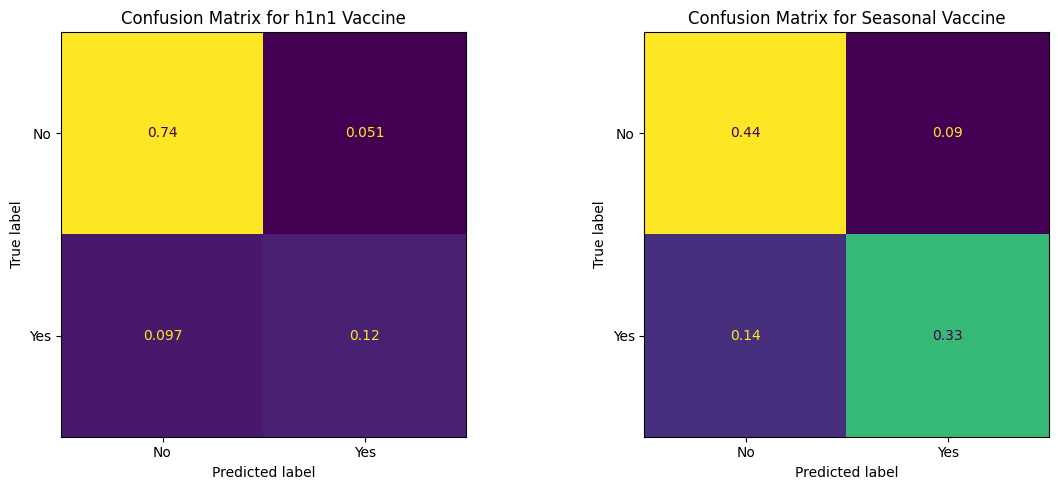

In [14]:
# confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred[:, 0], normalize='all')
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred[:, 1], normalize='all')
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

This results show that the model is performing impresively good for h1n1 vaccine, but seasonal vaccine is still tricky. H1N1 is clearly imbalance so it's easy for the model to correctly diferenciate between the classes but seasonal is more balanced. In other tests, we tried training two models instead of one, but the results weren't worth mentioning. Maybe, increasing the iterations would improve the results.

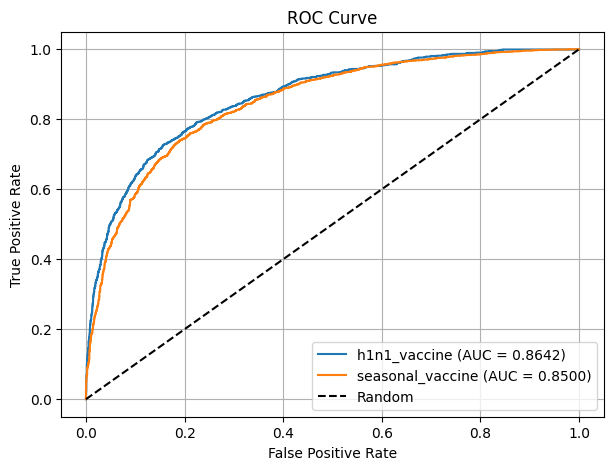

In [15]:
y_scores = [p[:, 1] for p in y_pred_proba]

plt.figure(figsize=(7, 5))
for i, y_score in enumerate(y_scores):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
    auc = roc_auc_score(y_test.iloc[:, i], y_score)
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Submission

This section contains the code to generate the submission file for the competition.

In [16]:
# competition submission
predictions = best_model.predict_proba(output)
        
h1n1_probs = predictions[0][:, 1]  # Probabilities of positive class for h1n1_vaccine
seasonal_probs = predictions[1][:, 1]  # Probabilities of positive class for seasonal_vaccine
predict = pd.DataFrame({
            "respondent_id": output.index,
            "h1n1_vaccine": h1n1_probs,
            "seasonal_vaccine": seasonal_probs
})
predict.set_index("respondent_id", inplace=True)
predict.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.144473,0.172420
26708,0.063072,0.026231
26709,0.215398,0.622903
26710,0.790885,0.900917
26711,0.466279,0.477951


Uncomment the following cell to save the results on an csv file to upload it to the competition.

In [17]:
# predict.to_csv("predictions.csv")

## Results

Below, there's an screenshot of the results of multiple runs of the model with mlflow. We can see that the execution time is around 20 minutes and that the accuracy and roc_auc almost didn't change for different train-test splits or random hyperparameters search.

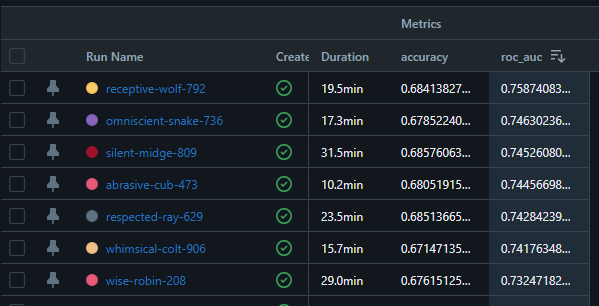

### Best model found

Metrics for our local validation set shows a performance similar but lower than the one with Random Forest Classifier.

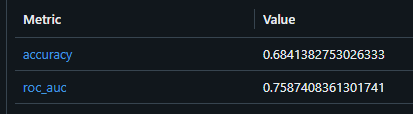

From the picture below we can see the parameters of the best model found, the others are set to default values.

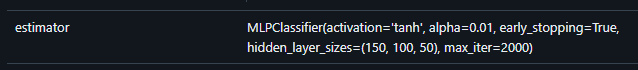

Here's the competition score for this model.   

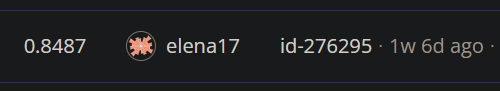

Again, as in the Random Forest Classifier, the model performs better in the competition (with a higher ROC_AUC score) than in the local validation set. This means that the model is generalizing well to the test set.

This aproach is a good one for quick prototyping of a neural network model, but it's not the best one for this competition.

As we will see on the Neural Networks section, the Keras models will have a
slightly lower score in the competition. This could very well be due to noise,
in that the results are extremely similar, although slightly higher here (0.826
for the neural network results, which results in a difference of 0.002~)

Even if the activation function here is different from the one in the Keras
models, trying to use this one there results in a worse performance, which
suggests that the main reason this one ended up having a higher score must be a
mix of luck, and some details in sklearn's neural network implementation.